In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import random as rnd
import collections

import SP_anisotropy_class as SPN

#3D plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
#Ignore the first 50 elements of the output
spacer = 50

In [3]:
def build_optimal_list_rec(L,sequences,p):
    #print(L)
    if len(L)==2**p:
        if check_cyclic_seq(L,sequences,p):
            L_final = L
            return(True,L_final)
        else:
            return(False,[0])
    else:
        #Add a 0
        L.append(0)
        last_seq = get_last_sequence(L,p)
        if check_last_seq(last_seq,sequences):
            sequences.append(last_seq)
            (success,L_final) = build_optimal_list_rec(L,sequences,p)
            if success:
                return(True,L_final)
        L.pop()
        
        #Add a 1
        L.append(1)
        last_seq = get_last_sequence(L,p)
        if check_last_seq(last_seq,sequences):
            sequences.append(last_seq)
            (success,L_final) = build_optimal_list_rec(L,sequences,p)
            if success:
                return(True,L_final)
        L.pop()
        return(False,[0])
            
def get_last_sequence(L,p):
    key = 0
    for k in range(p):
        key += (L[-p+k])*10**(p-k-1)
    key = int(key)
    return(key)


def check_last_seq(last_seq,sequences):
    if last_seq in sequences:
        return False
    else:
        return True

def check_cyclic_seq(L,sequences,p):
    L_cyclic = L[-p+1:]+L[:p-1]
    for k in range(p-1):
        last_seq = get_last_sequence(L_cyclic[k:k+p],p)
        if check_last_seq(last_seq,sequences)==False:
            return False
    return True

In [4]:
def Ridge_regression(S, Y, alpha):
    '''
    For a linear layer we can solve the weights by a direct method
    If the error function is the mean square error given by
        E = |Y - S * W |^2 + \alpha |W|^2
    where the L2 norm is being applied and the variables are
        Y = [Nsamples x Noutputs] is the desired output
        S = [Nsamples x Nweights] is the input signal
        W = [Nweights x Noutputs] is the weight matrix
    To minimise E we need to solve:
        S^T * Y = (S^T * S  + \alpha I) * W
        W = (S^T*S + \alpha I)^-1 * S^T * Y
    '''
    STS = np.matmul(S.T, S)
    STY = np.matmul(S.T, Y)
    Sdag = np.linalg.pinv(STS + alpha*np.eye(len(STS)))
    return(np.matmul(Sdag, STY))

def NARMA10(Ns):
    # Ns is the number of samples
    u = np.random.random(Ns+50+spacer)*0.5
    y = np.zeros(Ns+50+spacer)
    for k in range(10,Ns+50+spacer):
        y[k] = 0.3*y[k-1] + 0.05*y[k-1]*np.sum(y[k-10:k]) + 1.5*u[k-1]*u[k-10] + 0.1
    return(u[50:],y[50+spacer:])

def mask_NARMA10(m0,Nvirt):
    # Nvirt is the number of virtual nodes
    mask = []
    for i in range(Nvirt):
        mask.append(rnd.choice([-1,1])*m0)
    return(mask)

def mask_positive_ac(m0,Nvirt):
    #Mask with strong positive autocorrelation
    mask = []
    for i in range(Nvirt):
        mask.append(m0)
    return(mask)

def mask_negative_ac(m0,Nvirt):
    #Mask with strong negative autocorrelation
    mask = []
    for i in range(Nvirt):
        mask.append(2*((i%2)-0.5)*m0)
    return(mask)

def mask_random(m0,Nvirt):
    #Random mask
    mask = []
    for i in range(Nvirt):
        mask.append(2*(rnd.random()-0.5)*m0)
    return(mask)

def mask_switch(m0,Nvirt,K_switch_max):
    #Mask with as many "combinations of products" as possible
    mask = []
    K_switch = 1
    k_current = 0
    sign = 1
    while len(mask)<Nvirt:
        mask.append(sign*m0)
        k_current += 1
        if k_current==K_switch:
            k_current = 0
            if sign==1:
                sign=-1
            else:
                sign=1
                K_switch+=1
                if K_switch>K_switch_max:
                    K_switch=1
    return(mask)

def mask_max_sequences(m0,Nvirt):
    p = int(np.log2(Nvirt))
    L = [1]*p
    (success,L_final) = build_optimal_list_rec(L,[],p)
    mask = [0]*Nvirt
    N_L = len(L_final)
    for i in range(N_L):
        mask[i] = m0*2*(L_final[i]-0.5)
    for i in range(Nvirt-N_L):
        mask[-1-i] = m0*2*(L_final[-1-i]-0.5)
    return(mask)

def NRMSE(Y,Y_pred):
    var = np.var(Y)
    return np.sqrt(np.square(Y_pred-Y).mean()/var)

def NRMSE_list(y,y_pred):
    Y = np.array(y)
    Y_pred = np.array(y_pred)
    return(NRMSE(Y,Y_pred))

In [6]:
h = 0.4
theta_H = 90
k_s_0 = 0
phi = 45
f0 = 1e10
class Single_Node_Reservoir_NARMA10:
    
    def __init__(self, Nvirt, T_theta_ratio, m0, gamma, beta_prime = 10, k_off = 0., bias = True, joined_states = False, mask_type = "Default", K_switch_max = 4):
        self.Nin = 1
        self.Nvirt = Nvirt
        self.Nout = 1
        
        self.spn = SPN.SP_Network(h,theta_H,k_s_0,phi,beta_prime)
        SPN.calculate_energy_barriers(self.spn)
        self.T = 1./(self.spn.get_omega_prime()*f0)
        self.theta = self.T/T_theta_ratio
        self.tau = self.Nvirt*self.theta
        
        self.m0 = m0
        if mask_type=="Positive":
            self.M = mask_positive_ac(m0,Nvirt)
        elif mask_type=="Negative":
            self.M = mask_negative_ac(m0,Nvirt)
        elif mask_type=="Random":
            self.M = mask_random(m0,Nvirt)
        elif mask_type=="Max_Product":
            self.M = mask_switch(m0,Nvirt,K_switch_max)
        elif mask_type=="Max_Sequences":
            self.M = mask_max_sequences(m0,Nvirt)
        else:
            self.M = mask_NARMA10(m0,Nvirt)
            
        if bias:
            if joined_states:
                self.W = np.zeros((2*Nvirt+1,1))
            else:
                self.W = np.zeros((Nvirt+1,1))
        else:
            if joined_states:
                self.W = np.zeros((2*Nvirt,1))
            else:
                self.W = np.zeros((Nvirt,1))
        
        self.gamma = gamma
        self.k_off = k_off
        
        self.use_bias = bias
    
    def gen_signal(self, u):
        Ns = len(u)
        if self.use_bias:
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
        
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback
                SPN.calculate_energy_barriers(self.spn)
                self.spn.evolve(f0,self.theta)
                S[k,i] = self.spn.get_m()
        
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_fast(self,u):
        Ns = len(u)
        if self.use_bias:
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
        
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback 
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
        
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_fast_2_inputs(self, u, back_input_ratio):
        Ns = len(u)
        Nin = int(self.Nvirt*back_input_ratio)
        if self.use_bias:
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
            
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(Nin):
                #Input at k-1
                j = self.M[i]*u[k-1] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
            for i in range(Nin,self.Nvirt):
                #Input at k
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i] #Feedback 
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
                
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_fast_delayed_feedback(self, u, delay_fb):
        Ns = len(u)
        if self.use_bias:
            S = np.zeros((Ns,self.Nvirt+1))
        else:
            S = np.zeros((Ns,self.Nvirt))
            
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                self.spn.k_s = j + self.gamma*S[k-1,i-delay_fb] #Delayed Feedback 
                self.spn.evolve_fast(f0,self.theta)
                S[k,i] = self.spn.get_m_fast()
                
        if self.use_bias:
            for k in range(Ns):
                S[k,self.Nvirt] = 1
        
        return(S[spacer:])
    
    def gen_signal_delayed_feedback_without_SPN(self, u, delay_fb):
        Ns = len(u)
        if self.use_bias:
            J = np.zeros((Ns,self.Nvirt+1))
        else:
            J = np.zeros((Ns,self.Nvirt))
            
        # Artificial nonlinearity
        #f = lambda x: x
        f=np.tanh
            
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                J[k,i] = f(j + self.gamma*J[k-1,i-delay_fb]) #Delayed Feedback 
                
        if self.use_bias:
            for k in range(Ns):
                J[k,self.Nvirt] = 1
        
        return(J[spacer:])
    
    def gen_signal_without_SPN(self,u):
        Ns = len(u)
        if self.use_bias:
            J = np.zeros((Ns,self.Nvirt+1))
        else:
            J = np.zeros((Ns,self.Nvirt))
        
        for k in range(Ns):
            if k%100==0:
                print(k)
            for i in range(self.Nvirt):
                j = self.M[i]*u[k] + self.k_off #Offset
                J[k,i] = j + self.gamma*J[k-1,i] #J will be useful to test the role of memory and nonlinearity
        
        if self.use_bias:
            for k in range(Ns):
                J[k,self.Nvirt] = 1
        
        return(J[spacer:])
    
    def train(self, S, y, S_valid, y_valid):
        alphas = np.logspace(-15,0,20)
        alphas[0] = 0.
        
        Ns = S.shape[0]
        Ns_valid = S_valid.shape[0]
        Y = y.reshape((Ns,1))
        Y_valid = y_valid.reshape((Ns_valid,1))
        
        errs = np.zeros(alphas.shape)
        for i in range(len(alphas)):
            self.W = Ridge_regression(S, Y, alphas[i])
            Y_pred = np.array(self.predict(S)).reshape(Ns,1)
            Y_pred_valid = np.array(self.predict(S_valid)).reshape(Ns_valid,1)
            errs[i] = NRMSE(Y_valid, Y_pred_valid)
            print("alpha = " + str(alphas[i]) + " ; NRMSE (train) = " + str(int(1000*NRMSE(Y,Y_pred))/1000) + " ; NRMSE (validation) = " + str(int(1000*NRMSE(Y_valid, Y_pred_valid))/1000))
    
        alpha_opt = alphas[np.argmin(errs)]
        print('Optimal alpha = ' + str(alpha_opt) + ' with NRMSE (validation) = ' + str(np.min(errs)))
        self.W = Ridge_regression(S, Y, alpha_opt)
    
    def train_without_SPN(self, J, y, J_valid, y_valid):
        alphas = np.logspace(-15,0,20)
        alphas[0] = 0.
        
        Ns = J.shape[0]
        Ns_valid = J_valid.shape[0]
        Y = y.reshape((Ns,1))
        Y_valid = y_valid.reshape((Ns_valid,1))
        
        errs = np.zeros(alphas.shape)
        for i in range(len(alphas)):
            self.W = Ridge_regression(J, Y, alphas[i])
            Y_pred_valid = np.array(self.predict(J_valid)).reshape(Ns_valid,1)
            errs[i] = NRMSE(Y_valid, Y_pred_valid)
            print(alphas[i], NRMSE(Y_valid, Y_pred_valid))
    
        alpha_opt = alphas[np.argmin(errs)]
        print('Optimal alpha = '+str(alpha_opt)+' with NRMSE = '+str(np.min(errs)))
        self.W = Ridge_regression(J, Y, alpha_opt)
    
    def predict(self, S):
        Ns = S.shape[0]
        return(np.matmul(S, self.W).reshape(1,Ns).tolist()[0])
    
    #Time lists (in ns)
    
    def get_time_list_u(self, u):
        #We need to make sure that time_u has Ns elements with a delay tau
        Ns = len(u)
        t_u = 0
        time_u = [t_u]
        while len(time_u)<Ns:
            t_u += self.tau
            time_u.append(t_u)
        return(np.array(time_u)*1e9)
    
    def get_time_list_y(self, y):
        #We need to make sure that time_y has Ns elements with a delay tau
        Ns = len(y)
        t_y = spacer*self.tau
        time_y = [t_y]
        while len(time_y)<Ns:
            t_y += self.tau
            time_y.append(t_y)
        return(np.array(time_y)*1e9)
    
    def get_time_list_S(self, S):
        Ns = S.shape[0]
        return(np.arange(spacer*self.tau,(Ns+spacer)*self.tau,self.theta)*1e9)
    
    #Joined states
    
    def get_joined_states_signal(self, S):
        Ns = S.shape[0]
        if self.use_bias:
            S_joined = np.zeros((Ns,2*self.Nvirt+1))
        else:
            S_joined = np.zeros((Ns,2*self.Nvirt))
            
        for k in range(Ns):
            S_joined[k,:self.Nvirt] = S[k-1,:self.Nvirt]
            S_joined[k,self.Nvirt:2*self.Nvirt] = S[k,:self.Nvirt]
            if self.use_bias:
                S_joined[k,-1] = 1
        
        return(S_joined)

In [42]:
mask_type_list = ["Default","Positive","Negative","Random"]

Nv = 400
T_theta = .3
m0 = 7e-2
gamma = .28

N = 5

Ntrain = 1000
Nvalid = 1000
Ntest = 500

NRMSE_train_mean = []
NRMSE_valid_mean = []
NRMSE_test_mean = []
NRMSE_train_std = []
NRMSE_valid_std = []
NRMSE_test_std = []
NRMSE_train_total = []
NRMSE_valid_total = []
NRMSE_test_total = []

for MT in mask_type_list:
    print(MT)
    NRMSE_train = []
    NRMSE_valid = []
    NRMSE_test = []
    
    for i in range(N):
        (u,y) = NARMA10(Ntrain)
        (u_valid,y_valid) = NARMA10(Nvalid)
        (u_test,y_test) = NARMA10(Ntest)
        
        net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type=MT)

        S = net.gen_signal_fast_delayed_feedback(u,1)
        S_valid = net.gen_signal_fast_delayed_feedback(u_valid,1)
        S_test = net.gen_signal_fast_delayed_feedback(u_test,1)

        net.train(S,y,S_valid,y_valid)

        y_pred_train = net.predict(S)
        y_pred_valid = net.predict(S_valid)
        y_pred_test = net.predict(S_test)
        
        NRMSE_train.append(NRMSE_list(y,y_pred_train))
        NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
        NRMSE_test.append(NRMSE_list(y_test,y_pred_test))
        
    NRMSE_train_mean.append(np.mean(NRMSE_train))
    NRMSE_valid_mean.append(np.mean(NRMSE_valid))
    NRMSE_test_mean.append(np.mean(NRMSE_test))
    NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
    NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
    NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    NRMSE_train_total.append(NRMSE_train)
    NRMSE_valid_total.append(NRMSE_valid)
    NRMSE_test_total.append(NRMSE_test)

Default
0
100
0
100
0
alpha = 0.0 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.447
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.4

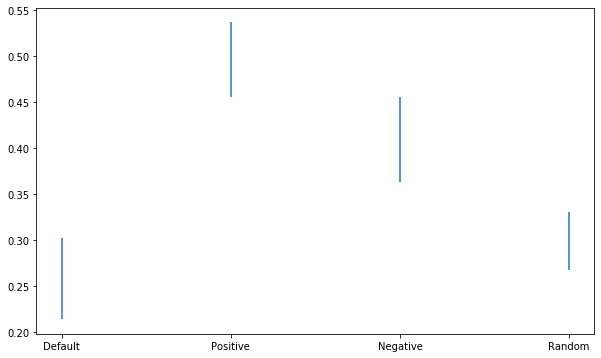

In [19]:
plt.figure(figsize=(10,6))
plt.errorbar(range(len(mask_type_list)),NRMSE_test_mean,NRMSE_test_std,linestyle='')
plt.xticks(range(len(mask_type_list)),mask_type_list)
plt.show()

In [57]:
K_switch_max_list = [-1,2,4,8,16]

Nv = 400
T_theta = .3
m0 = 7e-2
gamma = .28

N = 10

Ntrain = 1000
Nvalid = 1000
Ntest = 500

NRMSE_train_mean = []
NRMSE_valid_mean = []
NRMSE_test_mean = []
NRMSE_train_std = []
NRMSE_valid_std = []
NRMSE_test_std = []
NRMSE_train_total = []
NRMSE_valid_total = []
NRMSE_test_total = []

for K_s_m in K_switch_max_list:
    print(K_s_m)
    NRMSE_train = []
    NRMSE_valid = []
    NRMSE_test = []
    
    MT = "Max_Product"
    if K_s_m<1:
        MT = "Default"
        
    print(MT)
    
    for i in range(N):
        (u,y) = NARMA10(Ntrain)
        (u_valid,y_valid) = NARMA10(Nvalid)
        (u_test,y_test) = NARMA10(Ntest)
        
        net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type=MT,K_switch_max=K_s_m)

        S = net.gen_signal_fast_delayed_feedback(u,1)
        S_valid = net.gen_signal_fast_delayed_feedback(u_valid,1)
        S_test = net.gen_signal_fast_delayed_feedback(u_test,1)

        net.train(S,y,S_valid,y_valid)

        y_pred_train = net.predict(S)
        y_pred_valid = net.predict(S_valid)
        y_pred_test = net.predict(S_test)
        
        NRMSE_train.append(NRMSE_list(y,y_pred_train))
        NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
        NRMSE_test.append(NRMSE_list(y_test,y_pred_test))
        
    NRMSE_train_mean.append(np.mean(NRMSE_train))
    NRMSE_valid_mean.append(np.mean(NRMSE_valid))
    NRMSE_test_mean.append(np.mean(NRMSE_test))
    NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
    NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
    NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    NRMSE_train_total.append(NRMSE_train)
    NRMSE_valid_total.append(NRMSE_valid)
    NRMSE_test_total.append(NRMSE_test)

-1
Default
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.281
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.134 ; NRMSE (val

alpha = 0.000695192796177562 ; NRMSE (train) = 0.201 ; NRMSE (validation) = 0.268
alpha = 0.004281332398719396 ; NRMSE (train) = 0.287 ; NRMSE (validation) = 0.333
alpha = 0.026366508987303555 ; NRMSE (train) = 0.351 ; NRMSE (validation) = 0.381
alpha = 0.16237767391887242 ; NRMSE (train) = 0.382 ; NRMSE (validation) = 0.399
alpha = 1.0 ; NRMSE (train) = 0.406 ; NRMSE (validation) = 0.42
Optimal alpha = 1.8329807108324375e-05 with NRMSE (validation) = 0.2372058746850218
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.272
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.272
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.272
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.272
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.127 ; NRMSE (validation) = 0.272
alpha = 8.858667904

alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.244
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.243
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.15 ; NRMSE (validation) = 0.241
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.152 ; NRMSE (validation) = 0.234
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.163 ; NRMSE (validation) = 0.227
alpha = 0.000695192796177562 ; NRMSE (train) = 0.202 ; NRMSE (validation) = 0.253
alpha = 0.004281332398719396 ; NRMSE (train) = 0.275 ; NRMSE (validation) = 0.317
alpha = 0.

alpha = 1.0 ; NRMSE (train) = 0.802 ; NRMSE (validation) = 0.792
Optimal alpha = 0.004281332398719396 with NRMSE (validation) = 0.41505149226045485
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.414
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.414
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.414
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.413
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.41
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.367 ; NRMSE (validation) = 0.407
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.368 ; NRMSE (validation) = 0.406
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.37 ; NRMSE (validation) = 0.405
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.37 ; NRMSE (validation) = 0.404
alpha = 1.274274

alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.379 ; NRMSE (validation) = 0.416
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.382 ; NRMSE (validation) = 0.415
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.383 ; NRMSE (validation) = 0.414
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.385 ; NRMSE (validation) = 0.412
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.387 ; NRMSE (validation) = 0.412
alpha = 0.000695192796177562 ; NRMSE (train) = 0.39 ; NRMSE (validation) = 0.415
alpha = 0.004281332398719396 ; NRMSE (train) = 0.399 ; NRMSE (validation) = 0.429
alpha = 0.026366508987303555 ; NRMSE (train) = 0.449 ; NRMSE (validation) = 0.486
alpha = 0.16237767391887242 ; NRMSE (train) = 0.608 ; NRMSE (validation) = 0.637
alpha = 1.0 ; NRMSE (train) = 0.786 ; NRMSE (validation) = 0.8
Optimal alpha = 1.8329807108324375e-05 with NRMSE (validation) = 0.4125327026145474
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
al

0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.353 ; NRMSE (validation) = 0.456
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.353 ; NRMSE (validation) = 0.455
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.353 ; NRMSE (validation) = 0.455
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.353 ; NRMSE (validation) = 0.455
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.353 ; NRMSE (validation) = 0.456
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.354 ; NRMSE (validation) = 0.46
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.355 ; NRMSE (validation) = 0.453
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.357 ; NRMSE (validation) = 0.452
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.36 ; NRMSE (validation) = 0.449
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.363 ; NRMSE (validation) = 0.448
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.365 ; NRMSE (validation) = 0.446
alpha = 4.832930238571752e-07 ; NRMSE (

alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.341 ; NRMSE (validation) = 0.393
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.343 ; NRMSE (validation) = 0.39
alpha = 0.000695192796177562 ; NRMSE (train) = 0.346 ; NRMSE (validation) = 0.39
alpha = 0.004281332398719396 ; NRMSE (train) = 0.352 ; NRMSE (validation) = 0.394
alpha = 0.026366508987303555 ; NRMSE (train) = 0.38 ; NRMSE (validation) = 0.411
alpha = 0.16237767391887242 ; NRMSE (train) = 0.478 ; NRMSE (validation) = 0.494
alpha = 1.0 ; NRMSE (train) = 0.632 ; NRMSE (validation) = 0.647
Optimal alpha = 0.000695192796177562 with NRMSE (validation) = 0.39067624784281746
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.427
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.427
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.366 ; NRMSE (validation) = 0.427
alpha = 2.3357214690

alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.316 ; NRMSE (validation) = 0.535
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.316 ; NRMSE (validation) = 0.536
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.318 ; NRMSE (validation) = 0.536
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.32 ; NRMSE (validation) = 0.536
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.321 ; NRMSE (validation) = 0.536
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.323 ; NRMSE (validation) = 0.535
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.325 ; NRMSE (validation) = 0.534
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.329 ; NRMSE (validation) = 0.534
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.331 ; NRMSE (validation) = 0.535
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.332 ; NRMSE (validation) = 0.536
alpha = 0.000695192796177562 ; NRMSE (train) = 0.335 ; NRMSE (validation) = 0.537
alpha = 0.004281332398719396 ; NRMSE (train) = 0.34 ; NRMSE (validation) = 0.539
alph

alpha = 1.0 ; NRMSE (train) = 0.455 ; NRMSE (validation) = 0.463
Optimal alpha = 0.004281332398719396 with NRMSE (validation) = 0.39238960390483457
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.47
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.47
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.47
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.47
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.47
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.433 ; NRMSE (validation) = 0.479
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.426 ; NRMSE (validation) = 0.467
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.427 ; NRMSE (validation) = 0.465
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.429 ; NRMSE (validation) = 0.462
alpha = 1.27427498

alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.318 ; NRMSE (validation) = 0.378
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.318 ; NRMSE (validation) = 0.377
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.319 ; NRMSE (validation) = 0.374
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.323 ; NRMSE (validation) = 0.371
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.332 ; NRMSE (validation) = 0.371
alpha = 0.000695192796177562 ; NRMSE (train) = 0.34 ; NRMSE (validation) = 0.375
alpha = 0.004281332398719396 ; NRMSE (train) = 0.351 ; NRMSE (validation) = 0.381
alpha = 0.026366508987303555 ; NRMSE (train) = 0.369 ; NRMSE (validation) = 0.392
alpha = 0.16237767391887242 ; NRMSE (train) = 0.394 ; NRMSE (validation) = 0.409
alpha = 1.0 ; NRMSE (train) = 0.439 ; NRMSE (validation) = 0.448
Optimal alpha = 1.8329807108324375e-05 with NRMSE (validation) = 0.3716221734125093
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500


300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.294 ; NRMSE (validation) = 0.377
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.295 ; NRMSE (validation) = 0.375
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.297 ; NRMSE (validation) = 0.374
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.301 ; NRMSE (validation) = 0.374
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.304 ; NRMSE (validation) = 0.373
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.306 ; NRMSE (validation) = 0.373
alpha = 4.832930238571752e-07 ; NRMSE (train) =

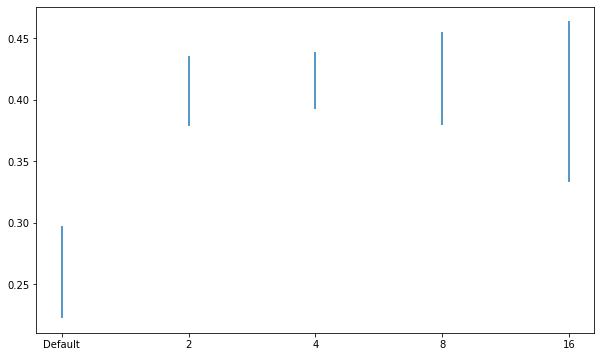

In [58]:
plt.figure(figsize=(10,6))
plt.errorbar(range(len(K_switch_max_list)),NRMSE_test_mean,NRMSE_test_std,linestyle='')
plt.xticks(range(len(K_switch_max_list)),["Default"]+K_switch_max_list[1:])
plt.show()

In [23]:
mask_type_list = ["Max_Sequences","Default"]

Nv = 512
T_theta = .3
m0 = 7e-2
gamma = .28

N = 5

Ntrain = 1000
Nvalid = 1000
Ntest = 500

NRMSE_train_mean = []
NRMSE_valid_mean = []
NRMSE_test_mean = []
NRMSE_train_std = []
NRMSE_valid_std = []
NRMSE_test_std = []
NRMSE_train_total = []
NRMSE_valid_total = []
NRMSE_test_total = []

for MT in mask_type_list:
    print(MT)
    NRMSE_train = []
    NRMSE_valid = []
    NRMSE_test = []
    
    for i in range(N):
        (u,y) = NARMA10(Ntrain)
        (u_valid,y_valid) = NARMA10(Nvalid)
        (u_test,y_test) = NARMA10(Ntest)
        
        net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type=MT)

        S = net.gen_signal_fast_delayed_feedback(u,1)
        S_valid = net.gen_signal_fast_delayed_feedback(u_valid,1)
        S_test = net.gen_signal_fast_delayed_feedback(u_test,1)

        net.train(S,y,S_valid,y_valid)

        y_pred_train = net.predict(S)
        y_pred_valid = net.predict(S_valid)
        y_pred_test = net.predict(S_test)
        
        NRMSE_train.append(NRMSE_list(y,y_pred_train))
        NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
        NRMSE_test.append(NRMSE_list(y_test,y_pred_test))
        
    NRMSE_train_mean.append(np.mean(NRMSE_train))
    NRMSE_valid_mean.append(np.mean(NRMSE_valid))
    NRMSE_test_mean.append(np.mean(NRMSE_test))
    NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
    NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
    NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    NRMSE_train_total.append(NRMSE_train)
    NRMSE_valid_total.append(NRMSE_valid)
    NRMSE_test_total.append(NRMSE_test)

Max_Sequences
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.158 ; NRMSE (validation) = 0.304
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.158 ; NRMSE (validation) = 0.304
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.158 ; NRMSE (validation) = 0.304
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.158 ; NRMSE (validation) = 0.304
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.158 ; NRMSE (validation) = 0.304
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.158 ; NRMSE (validation) = 0.304
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.158 ; NRMSE (validation) = 0.304
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.158 ; NRMSE (validation) = 0.304
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.158 ; NRMSE (validation) = 0.304
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.158 ; NRMSE (validation) = 0.304
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.158 ; NRMSE (

alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.134 ; NRMSE (validation) = 0.34
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.142 ; NRMSE (validation) = 0.32
alpha = 0.00011288378916846884 ; NRMSE (train) = 0.17 ; NRMSE (validation) = 0.306
alpha = 0.000695192796177562 ; NRMSE (train) = 0.222 ; NRMSE (validation) = 0.318
alpha = 0.004281332398719396 ; NRMSE (train) = 0.29 ; NRMSE (validation) = 0.351
alpha = 0.026366508987303555 ; NRMSE (train) = 0.352 ; NRMSE (validation) = 0.387
alpha = 0.16237767391887242 ; NRMSE (train) = 0.383 ; NRMSE (validation) = 0.405
alpha = 1.0 ; NRMSE (train) = 0.403 ; NRMSE (validation) = 0.416
Optimal alpha = 0.00011288378916846884 with NRMSE (validation) = 0.3067883752906368
Default
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
alpha = 0.0 ; NRMSE (train) = 0.105 ; NRMSE (validation) = 0.246
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.105 ; NRMSE (validation) = 0.246
alpha = 3.792

alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.209
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.209
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.209
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.209
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.209
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.209
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.209
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.209
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.208
alpha = 4.832930238571752e-07 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.207
alpha = 2.976351441631313e-06 ; NRMSE (train) = 0.1 ; NRMSE (validation) = 0.203
alpha = 1.8329807108324375e-05 ; NRMSE (train) = 0.103 ; NRMSE (validation) = 0.193
alpha = 0.000112883789

In [9]:
mask_type_list = ["Max_Sequences","Default"]

Nv = 512
T_theta = .3
m0 = 1e-1
gamma = .7

N = 10

Ntrain = 1000
Nvalid = 1000
Ntest = 500

NRMSE_train_mean = []
NRMSE_valid_mean = []
NRMSE_test_mean = []
NRMSE_train_std = []
NRMSE_valid_std = []
NRMSE_test_std = []
NRMSE_train_total = []
NRMSE_valid_total = []
NRMSE_test_total = []

for MT in mask_type_list:
    print(MT)
    NRMSE_train = []
    NRMSE_valid = []
    NRMSE_test = []
    
    for i in range(N):
        (u,y) = NARMA10(Ntrain)
        (u_valid,y_valid) = NARMA10(Nvalid)
        (u_test,y_test) = NARMA10(Ntest)
        
        net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type=MT)

        S = net.gen_signal_delayed_feedback_without_SPN(u,1)
        S_valid = net.gen_signal_delayed_feedback_without_SPN(u_valid,1)
        S_test = net.gen_signal_delayed_feedback_without_SPN(u_test,1)

        net.train_without_SPN(S,y,S_valid,y_valid)

        y_pred_train = net.predict(S)
        y_pred_valid = net.predict(S_valid)
        y_pred_test = net.predict(S_test)
        
        NRMSE_train.append(NRMSE_list(y,y_pred_train))
        NRMSE_valid.append(NRMSE_list(y_valid,y_pred_valid))
        NRMSE_test.append(NRMSE_list(y_test,y_pred_test))
        
    NRMSE_train_mean.append(np.mean(NRMSE_train))
    NRMSE_valid_mean.append(np.mean(NRMSE_valid))
    NRMSE_test_mean.append(np.mean(NRMSE_test))
    NRMSE_train_std.append(np.std(NRMSE_train,ddof=min(1,N-1)))
    NRMSE_valid_std.append(np.std(NRMSE_valid,ddof=min(1,N-1)))
    NRMSE_test_std.append(np.std(NRMSE_test,ddof=min(1,N-1)))
    NRMSE_train_total.append(NRMSE_train)
    NRMSE_valid_total.append(NRMSE_valid)
    NRMSE_test_total.append(NRMSE_test)

Max_Sequences
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.175187630249498
6.158482110660255e-15 0.1751838413794795
3.7926901907322537e-14 0.1751616117020082
2.335721469090121e-13 0.17406943124850857
1.438449888287666e-12 0.16839738355406716
8.858667904100833e-12 0.16397858166613816
5.4555947811685145e-11 0.16367785634361876
3.3598182862837877e-10 0.16937798416426733
2.06913808111479e-09 0.18977274089071988
1.2742749857031347e-08 0.23687021660801372
7.847599703514623e-08 0.31389538649689386
4.832930238571752e-07 0.3698214305576434
2.976351441631313e-06 0.386063518469246
1.8329807108324375e-05 0.3925194393949614
0.00011288378916846884 0.4025580069084393
0.000695192796177562 0.42214016133952303
0.004281332398719396 0.45852962056008273
0.026366508987303555 0.5564620815094299
0.16237767391887242 0.7163388087974859
1.0 0.7938874200631802
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.16367785634361876
0
100
200
300


7.847599703514623e-08 0.29209316547425795
4.832930238571752e-07 0.3570960615034244
2.976351441631313e-06 0.3857770867448584
1.8329807108324375e-05 0.3961750934394515
0.00011288378916846884 0.40219191475980937
0.000695192796177562 0.40838188082002
0.004281332398719396 0.42407210082533425
0.026366508987303555 0.5014995392552216
0.16237767391887242 0.6688425064679443
1.0 0.7574375647453447
Optimal alpha = 8.858667904100833e-12 with NRMSE = 0.16315054772591886
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.19127079898033766
6.158482110660255e-15 0.1919355898713469
3.7926901907322537e-14 0.19191154134173352
2.335721469090121e-13 0.19212356030479355
1.438449888287666e-12 0.18304201767264627
8.858667904100833e-12 0.17271256420133588
5.4555947811685145e-11 0.16855465538003528
3.3598182862837877e-10 0.17458642801286892
2.06913808111479e-09 0.19421733900094404
1.2742749857031347e-08 0.22606442999992166
7.847599703514623e-08 0.279

0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.53593992876678
6.158482110660255e-15 0.5351177197095228
3.7926901907322537e-14 0.5348522364103164
2.335721469090121e-13 0.5334609230193511
1.438449888287666e-12 0.5238943202083374
8.858667904100833e-12 0.49297980385307094
5.4555947811685145e-11 0.4453236823074372
3.3598182862837877e-10 0.40786402357147455
2.06913808111479e-09 0.3916464092504136
1.2742749857031347e-08 0.37842731702821425
7.847599703514623e-08 0.3825758626757653
4.832930238571752e-07 0.41308052530650285
2.976351441631313e-06 0.42526867927097534
1.8329807108324375e-05 0.42733344184266386
0.00011288378916846884 0.42900197890944847
0.000695192796177562 0.43163203343598694
0.004281332398719396 0.4317069202688163
0.026366508987303555 0.4740894262975462
0.16237767391887242 0.650394453164481
1.0 0.7757683749719863
Optimal alpha = 1.2742749857031347e-08 with NRMSE = 0.37842731702821425
0
100
200
300
400
500
600
700
8

In [22]:
p = 7
Nv = 2**p
net = Single_Node_Reservoir_NARMA10(Nv,.3,1,.28,mask_type="Max_Sequences")
counter = count_seq_net(net,p)
print(counter.keys())
print(counter.values())
print(2**p-len(counter.values()))

dict_keys([1111111, 1111110, 1111100, 1111000, 1110000, 1100000, 1000000, 0, 1, 10, 100, 1000, 10000, 100000, 1000001, 11, 110, 1100, 11000, 110000, 1100001, 1000010, 101, 1010, 10100, 101000, 1010000, 100001, 1000011, 111, 1110, 11100, 111000, 1110001, 1100010, 1000100, 1001, 10010, 100100, 1001000, 10001, 100010, 1000101, 1011, 10110, 101100, 1011000, 110001, 1100011, 1000110, 1101, 11010, 110100, 1101000, 1010001, 100011, 1000111, 1111, 11110, 111100, 1111001, 1110010, 1100100, 1001001, 10011, 100110, 1001100, 11001, 110010, 1100101, 1001010, 10101, 101010, 1010100, 101001, 1010010, 100101, 1001011, 10111, 101110, 1011100, 111001, 1110011, 1100110, 1001101, 11011, 110110, 1101100, 1011001, 110011, 1100111, 1001110, 11101, 111010, 1110100, 1101001, 1010011, 100111, 1001111, 11111, 111110, 1111101, 1111010, 1110101, 1101010, 1010101, 101011, 1010110, 101101, 1011010, 110101, 1101011, 1010111, 101111, 1011110, 111101, 1111011, 1110110, 1101101, 1011011, 110111, 1101110, 1011101, 111011

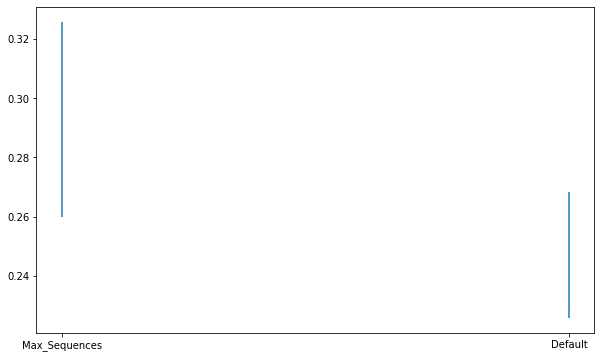

In [9]:
#Nvirt = 400
plt.figure(figsize=(10,6))
plt.errorbar(range(len(mask_type_list)),NRMSE_test_mean,NRMSE_test_std,linestyle='')
plt.xticks(range(len(mask_type_list)),mask_type_list)
plt.show()

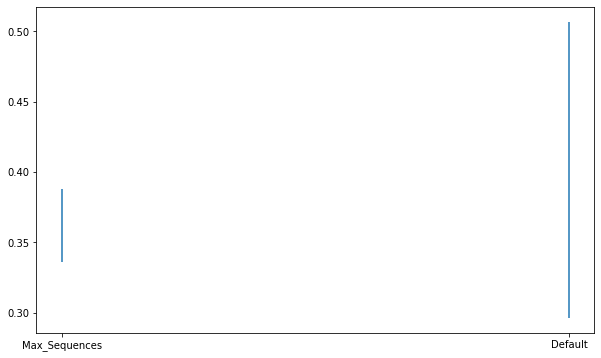

In [11]:
#Nvirt = 128
plt.figure(figsize=(10,6))
plt.errorbar(range(len(mask_type_list)),NRMSE_test_mean,NRMSE_test_std,linestyle='')
plt.xticks(range(len(mask_type_list)),mask_type_list)
plt.show()

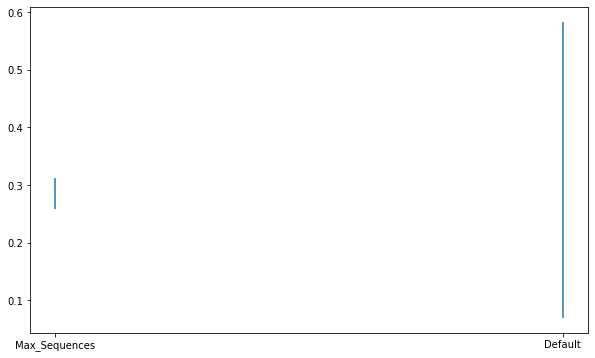

In [24]:
#Nvirt = 512
plt.figure(figsize=(10,6))
plt.errorbar(range(len(mask_type_list)),NRMSE_test_mean,NRMSE_test_std,linestyle='')
plt.xticks(range(len(mask_type_list)),mask_type_list)
plt.show()

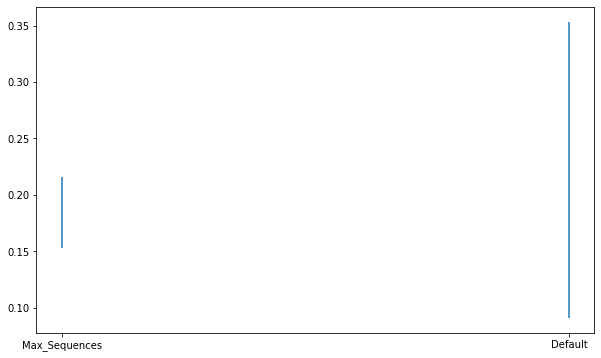

In [10]:
#Nvirt = 512
#Without SPN
plt.figure(figsize=(10,6))
plt.errorbar(range(len(mask_type_list)),NRMSE_test_mean,NRMSE_test_std,linestyle='')
plt.xticks(range(len(mask_type_list)),mask_type_list)
plt.show()

In [38]:
Ntrain = 1000
Nvalid = 1000

(u,y) = NARMA10(Ntrain)
(u_valid,y_valid) = NARMA10(Nvalid)

net = Single_Node_Reservoir_NARMA10(20,3e-1,7e-2,0.28,mask_type="Max_Product")
print(net.M)
S = net.gen_signal_fast_delayed_feedback(u, 1)
S_valid = net.gen_signal_fast_delayed_feedback(u_valid, 1)

net.train(S,y,S_valid,y_valid)

y_pred_train = net.predict(S)
y_pred_valid = net.predict(S_valid)

Ntest = 500
(u_test,y_test) = NARMA10(Ntest)
S_test = net.gen_signal_fast_delayed_feedback(u_test,1)
y_pred_test = net.predict(S_test)

[0.07, -0.07, 0.07, 0.07, -0.07, -0.07, 0.07, 0.07, 0.07, 0.07, -0.07, -0.07, -0.07, -0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
alpha = 0.0 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.395 ; NRMSE (validation) = 0.446
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.395 

NRMSE (test) = 0.34882277354954594


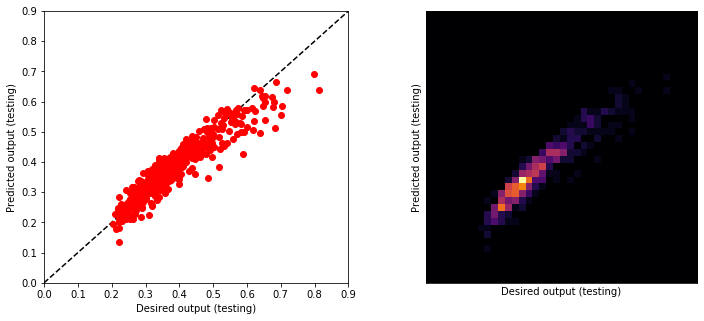

In [32]:
print("NRMSE (test) = "+str(NRMSE_list(y_test,y_pred_test)))
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.linspace(0,1.0),np.linspace(0,1.0), 'k--' )
plt.plot(y_test,y_pred_test,'ro')
plt.xlabel("Desired output (testing)")
plt.ylabel("Predicted output (testing)")
plt.xlim(0,0.9)
plt.ylim(0,0.9)
plt.subplot(122)
nbins = int(2*np.sqrt(Ntest))
H, xedges, yedges  = np.histogram2d(y_test,y_pred_test,bins = nbins,range=[[0, 1], [0, 1]])
H = H.T
plt.imshow(H,origin='low',cmap='inferno')
plt.xlabel("Desired output (testing)")
plt.ylabel("Predicted output (testing)")
plt.xticks([],[''])
plt.yticks([],[''])
plt.xlim(0,0.9*nbins)
plt.ylim(0,0.9*nbins)
plt.show()

In [33]:
Ntrain = 1000
Nvalid = 1000

(u,y) = NARMA10(Ntrain)
(u_valid,y_valid) = NARMA10(Nvalid)

net = Single_Node_Reservoir_NARMA10(200,3e-1,7e-2,0.28,joined_states=True)
S = net.gen_signal_fast_delayed_feedback(u, 1)
S_valid = net.gen_signal_fast_delayed_feedback(u_valid, 1)
S_joined = net.get_joined_states_signal(S)
S_valid_joined = net.get_joined_states_signal(S_valid)

net.train(S_joined,y,S_valid_joined,y_valid)

y_pred_train = net.predict(S_joined)
y_pred_valid = net.predict(S_valid_joined)

Ntest = 500
(u_test,y_test) = NARMA10(Ntest)
S_test = net.gen_signal_fast_delayed_feedback(u_test,1)
S_test_joined = net.get_joined_states_signal(S_test)
y_pred_test = net.predict(S_test_joined)

0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
alpha = 0.0 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 6.158482110660255e-15 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 3.7926901907322537e-14 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 2.335721469090121e-13 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 1.438449888287666e-12 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 8.858667904100833e-12 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 5.4555947811685145e-11 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 3.3598182862837877e-10 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 2.06913808111479e-09 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.73
alpha = 1.2742749857031347e-08 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.727
alpha = 7.847599703514623e-08 ; NRMSE (train) = 0.118 ; NRMSE (validation) = 0.712
alpha = 4.832930238571752

NRMSE (test) = 0.40595823632037975


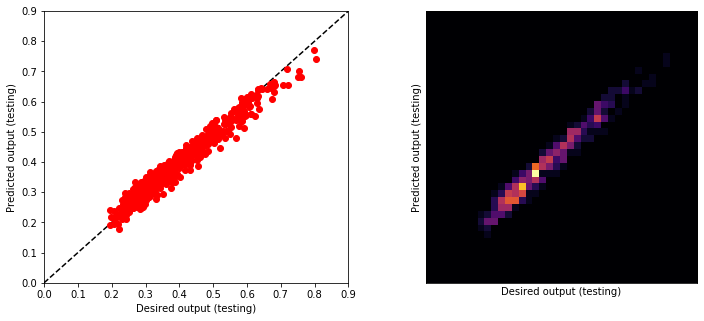

In [34]:
print("NRMSE (test) = "+str(NRMSE_list(y_test,y_pred_test)))
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.linspace(0,1.0),np.linspace(0,1.0), 'k--' )
plt.plot(y_test,y_pred_test,'ro')
plt.xlabel("Desired output (testing)")
plt.ylabel("Predicted output (testing)")
plt.xlim(0,0.9)
plt.ylim(0,0.9)
plt.subplot(122)
nbins = int(2*np.sqrt(Ntest))
H, xedges, yedges  = np.histogram2d(y_test,y_pred_test,bins = nbins,range=[[0, 1], [0, 1]])
H = H.T
plt.imshow(H,origin='low',cmap='inferno')
plt.xlabel("Desired output (testing)")
plt.ylabel("Predicted output (testing)")
plt.xticks([],[''])
plt.yticks([],[''])
plt.xlim(0,0.9*nbins)
plt.ylim(0,0.9*nbins)
plt.show()

In [28]:
def count_seq(mask_type,p,Nvirt,K_switch_max=4):
    mask = []
    if mask_type=="Positive":
        mask = mask_positive_ac(1,Nvirt)
    elif mask_type=="Negative":
        mask = mask_negative_ac(1,Nvirt)
    elif mask_type=="Max_Product":
        mask = mask_switch(1,Nvirt,K_switch_max)
    else:
        mask = mask_NARMA10(1,Nvirt)
    sequences = []
    for i in range(Nvirt-p+1):
        key = 0
        for k in range(p):
            key += ((mask[i+k]+1)/2)*10**(p-k-1)
        key = int(key)
        sequences.append(key)
    counter=collections.Counter(sequences)
    return(counter)

def count_seq_net(net,p):
    mask = net.M
    mask = mask+mask
    sequences = []
    for i in range(net.Nvirt):
        key = 0
        for k in range(p):
            key += ((mask[i+k]+1)/2)*10**(p-k-1)
        key = int(key)
        sequences.append(key)
    counter=collections.Counter(sequences)
    return(counter)

def count_mult_seq_net(net,p):
    mask = net.M
    mask = mask+mask
    sequences = []
    for i in range(net.Nvirt):
        key = 0
        M = 1
        for k in range(p):
            M *= mask[i+k]
            key += ((M+1)/2)*10**(p-k-1)
        key = int(key)
        sequences.append(key)
    counter=collections.Counter(sequences)
    return(counter)

In [ ]:
mask_type_1 = "Max_Product"
mask_type_2 = "Default"
p = 8
Nv = 300
K_s_m = 6
counter_1 = count_seq(mask_type_1,p,Nv,K_switch_max = K_s_m)
print(counter_1.keys())
print(counter_1.values())
print(2**p-len(counter_1.values()))
counter_2 = count_seq(mask_type_2,p,Nv,K_switch_max = K_s_m)
print(counter_2.keys())
print(counter_2.values())
print(2**p-len(counter_2.values()))
list_missed = []
for x in counter_2.keys():
    list_missed.append(x)
for x in counter_1.keys():
    if x in list_missed:
        list_missed.remove(x)
print(list_missed)

In [5]:
p = 3
L = [1]*p
(success,L_final) = build_optimal_list_rec(L,[],p)
print(L_final)

[1, 1, 1, 0, 0, 0, 1, 0]


In [18]:
def get_rank(net):
    mask = net.M
    Nv = net.Nvirt
    Matrix = np.zeros((Nv,Nv))
    for i in range(Nv):
        for j in range(Nv):
            Matrix[i,j] = mask[(i+j)%Nv]
    return(np.linalg.matrix_rank(Matrix))

def get_auto_correlation_func(net):
    mask = net.M
    Nv = net.Nvirt
    auto_corr = []
    for k in range(Nv//2):
        expectancy = 0
        for i in range(Nv):
            expectancy += mask[i]*mask[(i+k)%Nv]
        expectancy /= Nv
        auto_corr.append(expectancy)
    return auto_corr

def get_mult_rank(net):
    mask = net.M
    Nv = net.Nvirt
    Matrix = np.zeros((Nv,Nv))
    for i in range(Nv):
        M = 1
        for j in range(Nv):
            M *= mask[(i+j)%Nv]
            Matrix[i,j] = M
    return(np.linalg.matrix_rank(Matrix))

In [80]:
Ntrain = 1000
Nvalid = 1000
Ntest = 500

Nv = 512
T_theta = 1e-2
m0 = 1e-1
gamma = .7

N = 100

NRMSEs_1 = []
Ranks_1 = []

for i in range(N):
    (u,y) = NARMA10(Ntrain)
    (u_valid,y_valid) = NARMA10(Nvalid)
    (u_test,y_test) = NARMA10(Ntest)

    net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type="Default")

    J = net.gen_signal_delayed_feedback_without_SPN(u,1)
    J_valid = net.gen_signal_delayed_feedback_without_SPN(u_valid,1)
    J_test = net.gen_signal_delayed_feedback_without_SPN(u_test,1)

    net.train_without_SPN(J,y,J_valid,y_valid)

    y_pred_test = net.predict(J_test)
    
    NRMSE_loc = NRMSE_list(y_test,y_pred_test)
    rank_loc = get_rank(net)
    print(NRMSE_loc)
    print(rank_loc)
    NRMSEs_1.append(NRMSE_loc)
    Ranks_1.append(rank_loc)

0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.23228229526155325
6.158482110660255e-15 0.23209017664691767
3.7926901907322537e-14 0.23222312413633714
2.335721469090121e-13 0.23160281225292914
1.438449888287666e-12 0.23086511800037016
8.858667904100833e-12 0.22931549234046156
5.4555947811685145e-11 0.23196706580532198
3.3598182862837877e-10 0.241324852082919
2.06913808111479e-09 0.25431703736922545
1.2742749857031347e-08 0.2794725984527557
7.847599703514623e-08 0.3414123414466782
4.832930238571752e-07 0.403765252456245
2.976351441631313e-06 0.4267023225458751
1.8329807108324375e-05 0.4368264446925508
0.00011288378916846884 0.4502588026255657
0.000695192796177562 0.4668617995186517
0.004281332398719396 0.4936163567887093
0.026366508987303555 0.5668874862094315
0.16237767391887242 0.7097727732705211
1.0 0.800718119605007
Optimal alpha = 8.858667904100833e-12 with NRMSE = 0.22931549234046156
0.15817561926392504
512
0
100
20

8.858667904100833e-12 0.31614389060853965
5.4555947811685145e-11 0.2884295014143296
3.3598182862837877e-10 0.2650084570737752
2.06913808111479e-09 0.2408179898786339
1.2742749857031347e-08 0.22493633852129463
7.847599703514623e-08 0.2631073641736183
4.832930238571752e-07 0.3398695485954579
2.976351441631313e-06 0.3736620434918597
1.8329807108324375e-05 0.3842888435046476
0.00011288378916846884 0.39122105343582925
0.000695192796177562 0.4014885810672788
0.004281332398719396 0.41893647477840723
0.026366508987303555 0.49148917108564777
0.16237767391887242 0.6666858961814904
1.0 0.776253009821284
Optimal alpha = 1.2742749857031347e-08 with NRMSE = 0.22493633852129463
0.231880509377659
512
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.16106998349246107
6.158482110660255e-15 0.16104158738783356
3.7926901907322537e-14 0.16102606998819036
2.335721469090121e-13 0.16064377902697655
1.438449888287666e-12 0.15897900540436363
8.858

1.8329807108324375e-05 0.3775349573182457
0.00011288378916846884 0.38549074749630347
0.000695192796177562 0.39579210521435176
0.004281332398719396 0.4151155114544186
0.026366508987303555 0.49077793630316247
0.16237767391887242 0.6633202434531814
1.0 0.7718799079264872
Optimal alpha = 3.3598182862837877e-10 with NRMSE = 0.14201234025896328
0.18911108170444263
512
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.1660124896608257
6.158482110660255e-15 0.1657752005265338
3.7926901907322537e-14 0.1657954904279609
2.335721469090121e-13 0.16564678025806098
1.438449888287666e-12 0.16409614003222234
8.858667904100833e-12 0.15900706897814648
5.4555947811685145e-11 0.15315302697423036
3.3598182862837877e-10 0.1527734561342451
2.06913808111479e-09 0.15823860646943969
1.2742749857031347e-08 0.1769926473953179
7.847599703514623e-08 0.23844813452122365
4.832930238571752e-07 0.31907169861686424
2.976351441631313e-06 0.35112129356838145
1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars


100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.18255167994699797
6.158482110660255e-15 0.18200816759192395
3.7926901907322537e-14 0.18245434487463352
2.335721469090121e-13 0.18192359312815315
1.438449888287666e-12 0.17980472202417072
8.858667904100833e-12 0.17183166306939474
5.4555947811685145e-11 0.16278968525691592
3.3598182862837877e-10 0.16144515568620274
2.06913808111479e-09 0.17011421188405182
1.2742749857031347e-08 0.19976755872818233
7.847599703514623e-08 0.27776965263077213
4.832930238571752e-07 0.35216512231483216
2.976351441631313e-06 0.37880101147490497
1.8329807108324375e-05 0.38735357836491363
0.00011288378916846884 0.39654678831433415
0.000695192796177562 0.4090536307758943
0.004281332398719396 0.4292632128255991
0.026366508987303555 0.5021153138342405
0.16237767391887242 0.6715661756136532
1.0 0.7798327726248662
Optimal alpha = 3.3598182862837877e-10 with NRMSE = 0.16144515568620274
nan
512


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in square


0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.18803394515648744
6.158482110660255e-15 0.1880059182059363
3.7926901907322537e-14 0.18784272208072483
2.335721469090121e-13 0.18786921460971737
1.438449888287666e-12 0.18685392018804609
8.858667904100833e-12 0.18437060713186934
5.4555947811685145e-11 0.18393532218880637
3.3598182862837877e-10 0.1896589302948001
2.06913808111479e-09 0.20177767325356205
1.2742749857031347e-08 0.24000368639419759
7.847599703514623e-08 0.3196150908031679
4.832930238571752e-07 0.38972272316077916
2.976351441631313e-06 0.41914975238327024
1.8329807108324375e-05 0.4291687879580031
0.00011288378916846884 0.4365204372820974
0.000695192796177562 0.44675022634823214
0.004281332398719396 0.4657847540441779
0.026366508987303555 0.5353599464559367
0.16237767391887242 0.6974995186276709
1.0 0.803401628992622
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.18393532218880637
0.42832392972746525
512
0


1.438449888287666e-12 0.1610998862162381
8.858667904100833e-12 0.15548085844313494
5.4555947811685145e-11 0.1531823792975505
3.3598182862837877e-10 0.16044517003100445
2.06913808111479e-09 0.17452919352875143
1.2742749857031347e-08 0.20725052959413923
7.847599703514623e-08 0.2808455055450807
4.832930238571752e-07 0.34960909200259843
2.976351441631313e-06 0.373882013314129
1.8329807108324375e-05 0.381569665448972
0.00011288378916846884 0.38863544951182094
0.000695192796177562 0.39698643947333384
0.004281332398719396 0.4159219838719422
0.026366508987303555 0.4972489237292377
0.16237767391887242 0.6673922992639262
1.0 0.7687895487783933
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.1531823792975505
0.1919108801216072
512
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.3148882013372662
6.158482110660255e-15 0.3146656224426136
3.7926901907322537e-14 0.31428215634551593
2.335721469090121e-13 0.31286303185676834
1.43844

7.847599703514623e-08 0.25575712888096575
4.832930238571752e-07 0.3381280519093118
2.976351441631313e-06 0.3717906325124159
1.8329807108324375e-05 0.37657596041036445
0.00011288378916846884 0.3766921089833789
0.000695192796177562 0.3832043823758766
0.004281332398719396 0.39646608314685905
0.026366508987303555 0.4581238804238431
0.16237767391887242 0.6346881207028301
1.0 0.7526631966102438
Optimal alpha = 3.3598182862837877e-10 with NRMSE = 0.18225630843111237
0.17578422614566205
512
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.17134347960546023
6.158482110660255e-15 0.1714512004027671
3.7926901907322537e-14 0.1712415778373368
2.335721469090121e-13 0.170930050869024
1.438449888287666e-12 0.16851082722375268
8.858667904100833e-12 0.15985731658441357
5.4555947811685145e-11 0.14521196239352918
3.3598182862837877e-10 0.13640253952791312
2.06913808111479e-09 0.14332460963162985
1.2742749857031347e-08 0.17225460177698054
7.8

0.004281332398719396 0.4228192597523913
0.026366508987303555 0.5119770262206522
0.16237767391887242 0.6855923796560404
1.0 0.7935886207558049
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.15872896797009697
0.17236394176193037
512
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.20304784552798064
6.158482110660255e-15 0.20303477559557376
3.7926901907322537e-14 0.20296003804205529
2.335721469090121e-13 0.20254239551326153
1.438449888287666e-12 0.20037362989698584
8.858667904100833e-12 0.19286949503657277
5.4555947811685145e-11 0.1840785983951409
3.3598182862837877e-10 0.18015773720230585
2.06913808111479e-09 0.18613599398391528
1.2742749857031347e-08 0.22016575992783682
7.847599703514623e-08 0.29337983152010694
4.832930238571752e-07 0.3600348293567166
2.976351441631313e-06 0.38103913905321385
1.8329807108324375e-05 0.3849830454376112
0.00011288378916846884 0.39474092983690184
0.000695192796177562 0.4129413996394988


100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.2040197734039171
6.158482110660255e-15 0.2038319098949501
3.7926901907322537e-14 0.20372536286559983
2.335721469090121e-13 0.20336706376456773
1.438449888287666e-12 0.20076683711380383
8.858667904100833e-12 0.19266506457612373
5.4555947811685145e-11 0.18485869733744628
3.3598182862837877e-10 0.1888401298810386
2.06913808111479e-09 0.20632337299269585
1.2742749857031347e-08 0.23590439062199092
7.847599703514623e-08 0.2991353417491515
4.832930238571752e-07 0.3721985111664941
2.976351441631313e-06 0.4026581156707038
1.8329807108324375e-05 0.4160216305175727
0.00011288378916846884 0.430641009413519
0.000695192796177562 0.4497741809289023
0.004281332398719396 0.4769150061354722
0.026366508987303555 0.5483852341418538
0.16237767391887242 0.7033669184839029
1.0 0.8071690562689243
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.18485869733744628
0.15631961742928296
512
0
100
20

5.4555947811685145e-11 0.15246332697376502
3.3598182862837877e-10 0.1522366842364862
2.06913808111479e-09 0.16353967335023842
1.2742749857031347e-08 0.19689750719289073
7.847599703514623e-08 0.2770504509409857
4.832930238571752e-07 0.34673400813453953
2.976351441631313e-06 0.37165144728169186
1.8329807108324375e-05 0.3804055388408617
0.00011288378916846884 0.38643008561552783
0.000695192796177562 0.3941902634344106
0.004281332398719396 0.40831454953060436
0.026366508987303555 0.4723774116473316
0.16237767391887242 0.6409002230815247
1.0 0.751672799957857
Optimal alpha = 3.3598182862837877e-10 with NRMSE = 0.1522366842364862
0.18462752134450988
512
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.1958929922595134
6.158482110660255e-15 0.19587253446800584
3.7926901907322537e-14 0.19574156804583256
2.335721469090121e-13 0.19497455791964222
1.438449888287666e-12 0.19131156893219245
8.858667904100833e-12 0.18425625290039144
5.

0.18490559270737505
512
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.1523968869323151
6.158482110660255e-15 0.15236158942962238
3.7926901907322537e-14 0.1523010582638157
2.335721469090121e-13 0.1519427922188579
1.438449888287666e-12 0.149976684598191
8.858667904100833e-12 0.14312111776464137
5.4555947811685145e-11 0.13523012479516755
3.3598182862837877e-10 0.13711617575305016
2.06913808111479e-09 0.150246333403683
1.2742749857031347e-08 0.1784863529299785
7.847599703514623e-08 0.24395661541924984
4.832930238571752e-07 0.316743923913766
2.976351441631313e-06 0.3468662543725035
1.8329807108324375e-05 0.35957726935066825
0.00011288378916846884 0.3741541491118157
0.000695192796177562 0.391353835121209
0.004281332398719396 0.42050774811404645
0.026366508987303555 0.5080812933930129
0.16237767391887242 0.6827945793033461
1.0 0.7888140281707746
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.13523012479516755
0.1714476

1.438449888287666e-12 0.18057079663947762
8.858667904100833e-12 0.17367315107970932
5.4555947811685145e-11 0.16845757115356866
3.3598182862837877e-10 0.17246045850651093
2.06913808111479e-09 0.1826014481822975
1.2742749857031347e-08 0.20004572621346334
7.847599703514623e-08 0.2627889937962695
4.832930238571752e-07 0.3426993121279189
2.976351441631313e-06 0.3708137408131705
1.8329807108324375e-05 0.378826572483057
0.00011288378916846884 0.3884938089065782
0.000695192796177562 0.40121607072910526
0.004281332398719396 0.42581849363340596
0.026366508987303555 0.5121793454489851
0.16237767391887242 0.694647101692514
1.0 0.8069612065896682
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.16845757115356866
0.16744274622042582
512
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.1869375773743733
6.158482110660255e-15 0.1867049537517015
3.7926901907322537e-14 0.18651714226525606
2.335721469090121e-13 0.18649866359965214
1.438

2.976351441631313e-06 0.4297174340129201
1.8329807108324375e-05 0.44244510064347575
0.00011288378916846884 0.45945667890127095
0.000695192796177562 0.48171887939248925
0.004281332398719396 0.5094806368285781
0.026366508987303555 0.5761403087356927
0.16237767391887242 0.7255933890241716
1.0 0.8265845631287986
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.20532482929374582
0.17086350554030455
512
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.16721834298182173
6.158482110660255e-15 0.16720531410895115
3.7926901907322537e-14 0.16718845134708546
2.335721469090121e-13 0.16710459062144897
1.438449888287666e-12 0.166486204387458
8.858667904100833e-12 0.16509693801173178
5.4555947811685145e-11 0.1652722903111319
3.3598182862837877e-10 0.17063081723735551
2.06913808111479e-09 0.1853163770576861
1.2742749857031347e-08 0.21925494969091097
7.847599703514623e-08 0.291419218118485
4.832930238571752e-07 0.36354169790673635
2.9

0.16237767391887242 0.6673358304976879
1.0 0.7811761065645803
Optimal alpha = 3.3598182862837877e-10 with NRMSE = 0.16884909216148855
0.20863933220189268
512


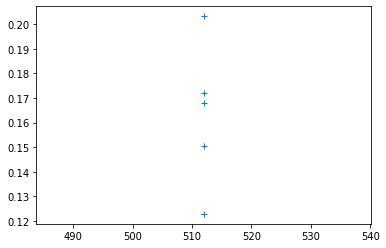

In [35]:
plt.plot(Ranks,NRMSEs,'+')
plt.show()

In [81]:
Ntrain = 1000
Nvalid = 1000
Ntest = 500

Nv = 512
T_theta = 1e-2
m0 = 1e-1
gamma = .7

N = 100

NRMSEs_2 = []
Ranks_2 = []

for i in range(N):
    (u,y) = NARMA10(Ntrain)
    (u_valid,y_valid) = NARMA10(Nvalid)
    (u_test,y_test) = NARMA10(Ntest)

    net = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type="Max_Sequences")

    J = net.gen_signal_delayed_feedback_without_SPN(u,1)
    J_valid = net.gen_signal_delayed_feedback_without_SPN(u_valid,1)
    J_test = net.gen_signal_delayed_feedback_without_SPN(u_test,1)

    net.train_without_SPN(J,y,J_valid,y_valid)

    y_pred_test = net.predict(J_test)
    
    NRMSE_loc = NRMSE_list(y_test,y_pred_test)
    rank_loc = get_rank(net)
    print(NRMSE_loc)
    print(rank_loc)
    NRMSEs_2.append(NRMSE_loc)
    Ranks_2.append(rank_loc)

0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.1964840490088328
6.158482110660255e-15 0.19713981941929234
3.7926901907322537e-14 0.1966584811856175
2.335721469090121e-13 0.19646373646759993
1.438449888287666e-12 0.1879084606502443
8.858667904100833e-12 0.18123753350489172
5.4555947811685145e-11 0.1788774579236956
3.3598182862837877e-10 0.18163938500534862
2.06913808111479e-09 0.2013759562269278
1.2742749857031347e-08 0.24045117007009648
7.847599703514623e-08 0.2981225967038862
4.832930238571752e-07 0.35125540621019574
2.976351441631313e-06 0.3723624789880479
1.8329807108324375e-05 0.3800252328139465
0.00011288378916846884 0.3883040022392465
0.000695192796177562 0.40030542558736504
0.004281332398719396 0.42245192710737417
0.026366508987303555 0.5095802994761944
0.16237767391887242 0.6732794930073495
1.0 0.7595771814238482
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.1788774579236956
0.16835785094462377
511
0
100

5.4555947811685145e-11 0.2217969490487028
3.3598182862837877e-10 0.2297942967061939
2.06913808111479e-09 0.25422662195752105
1.2742749857031347e-08 0.3001026121894843
7.847599703514623e-08 0.3709913730451118
4.832930238571752e-07 0.42744715482607853
2.976351441631313e-06 0.4459085628371543
1.8329807108324375e-05 0.45082132306725686
0.00011288378916846884 0.45744021527442974
0.000695192796177562 0.46593698304610387
0.004281332398719396 0.4791005475145355
0.026366508987303555 0.5486685976650654
0.16237767391887242 0.70301029108656
1.0 0.7868095057356617
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.2217969490487028
0.19335917155997626
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.3131761381769398
6.158482110660255e-15 0.31323567707204036
3.7926901907322537e-14 0.3121717765355813
2.335721469090121e-13 0.3116573104023778
1.438449888287666e-12 0.3113730555544242
8.858667904100833e-12 0.3071552314461196
5.4555947

1.8329807108324375e-05 0.3600420182892389
0.00011288378916846884 0.3678964773870852
0.000695192796177562 0.38011085644207526
0.004281332398719396 0.4067832228863905
0.026366508987303555 0.5071733971563689
0.16237767391887242 0.6854815157422125
1.0 0.7744883481832364
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.1514595712028192
0.1612326486489604
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.23502817245916224
6.158482110660255e-15 0.23487768237650578
3.7926901907322537e-14 0.23631895454229723
2.335721469090121e-13 0.23597463474215394
1.438449888287666e-12 0.22851717184405348
8.858667904100833e-12 0.22206755799992406
5.4555947811685145e-11 0.21766660668015575
3.3598182862837877e-10 0.21918580507666208
2.06913808111479e-09 0.2313214827193473
1.2742749857031347e-08 0.2694854929149991
7.847599703514623e-08 0.3362306914534337
4.832930238571752e-07 0.3882361193887833
2.976351441631313e-06 0.40727997584695314
1.83

0.18065970011029292
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.16713895940461918
6.158482110660255e-15 0.1670588345904192
3.7926901907322537e-14 0.16744958949293473
2.335721469090121e-13 0.16627036962220312
1.438449888287666e-12 0.1630313067758728
8.858667904100833e-12 0.1589662660558692
5.4555947811685145e-11 0.15872620770090343
3.3598182862837877e-10 0.16328131278442495
2.06913808111479e-09 0.17652739373150064
1.2742749857031347e-08 0.20667228850480612
7.847599703514623e-08 0.2635804182428812
4.832930238571752e-07 0.31783133534251506
2.976351441631313e-06 0.3431264240906385
1.8329807108324375e-05 0.35562921497475974
0.00011288378916846884 0.371246429934973
0.000695192796177562 0.39286878858799046
0.004281332398719396 0.4282332002569678
0.026366508987303555 0.5282937379511864
0.16237767391887242 0.7022243750717996
1.0 0.7922959877868684
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.15872620770090343
0.1

2.335721469090121e-13 0.19947500497498108
1.438449888287666e-12 0.19061087700582502
8.858667904100833e-12 0.18550938529330463
5.4555947811685145e-11 0.1831302406604003
3.3598182862837877e-10 0.19020306255737313
2.06913808111479e-09 0.2067857331457939
1.2742749857031347e-08 0.23602363987257866
7.847599703514623e-08 0.2994174285545337
4.832930238571752e-07 0.3659386309548859
2.976351441631313e-06 0.39182124190138384
1.8329807108324375e-05 0.4011418720416593
0.00011288378916846884 0.4118093774347169
0.000695192796177562 0.4285205938642765
0.004281332398719396 0.4567166422453961
0.026366508987303555 0.5462217302058797
0.16237767391887242 0.7098539976082636
1.0 0.7940074444709024
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.1831302406604003
0.1725348555068834
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.20541370883252594
6.158482110660255e-15 0.20521384912051283
3.7926901907322537e-14 0.20545358186014243
2.335

1.2742749857031347e-08 0.2328400614176819
7.847599703514623e-08 0.3035108873389555
4.832930238571752e-07 0.36865724783075554
2.976351441631313e-06 0.39597022733759096
1.8329807108324375e-05 0.4070824028896319
0.00011288378916846884 0.41581181168664766
0.000695192796177562 0.42476025560046354
0.004281332398719396 0.4413086415053152
0.026366508987303555 0.5178993787941816
0.16237767391887242 0.6803889548101759
1.0 0.7663577402370544
Optimal alpha = 5.4555947811685145e-11 with NRMSE = 0.17127497746163406
0.17918159030397385
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.23431760514664934
6.158482110660255e-15 0.23387658987614146
3.7926901907322537e-14 0.23365897569150468
2.335721469090121e-13 0.23286393559947333
1.438449888287666e-12 0.22600941875355715
8.858667904100833e-12 0.21292428382778908
5.4555947811685145e-11 0.2094723449660484
3.3598182862837877e-10 0.21853597269357514
2.06913808111479e-09 0.2379091809405792
1

0.000695192796177562 0.39013518733037694
0.004281332398719396 0.4146433268342459
0.026366508987303555 0.5027310305647862
0.16237767391887242 0.6759288799399578
1.0 0.7684509322664462
Optimal alpha = 1.438449888287666e-12 with NRMSE = 0.1814075454977581
0.19746557289229022
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.23015366708872098
6.158482110660255e-15 0.23005800998024914
3.7926901907322537e-14 0.22978443938006218
2.335721469090121e-13 0.22951718603498936
1.438449888287666e-12 0.22426930427392897
8.858667904100833e-12 0.22235142553507012
5.4555947811685145e-11 0.22072359967115796
3.3598182862837877e-10 0.22214037201689024
2.06913808111479e-09 0.23474275927923438
1.2742749857031347e-08 0.2672624722699386
7.847599703514623e-08 0.3172373302676376
4.832930238571752e-07 0.3612914757856536
2.976351441631313e-06 0.38426951810737214
1.8329807108324375e-05 0.3977120754970653
0.00011288378916846884 0.41174071444478305
0.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars


100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 nan


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: overflow encountered in square


6.158482110660255e-15 nan
3.7926901907322537e-14 nan
2.335721469090121e-13 nan
1.438449888287666e-12 nan
8.858667904100833e-12 nan
5.4555947811685145e-11 nan
3.3598182862837877e-10 nan
2.06913808111479e-09 nan
1.2742749857031347e-08 nan
7.847599703514623e-08 nan
4.832930238571752e-07 nan
2.976351441631313e-06 nan
1.8329807108324375e-05 nan
0.00011288378916846884 nan
0.000695192796177562 nan
0.004281332398719396 nan
0.026366508987303555 nan
0.16237767391887242 nan
1.0 nan
Optimal alpha = 0.0 with NRMSE = nan
0.25629756708971396
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.1799657401759683
6.158482110660255e-15 0.17994308243985363
3.7926901907322537e-14 0.17981871517850317
2.335721469090121e-13 0.17875338685193834
1.438449888287666e-12 0.17657413708510283
8.858667904100833e-12 0.17049162418477648
5.4555947811685145e-11 0.1683630187985774
3.3598182862837877e-10 0.1735986250650057
2.06913808111479e-09 0.19376622398586

0.004281332398719396 0.43601103993929724
0.026366508987303555 0.5115059548695001
0.16237767391887242 0.6848689682779302
1.0 0.7781127356855954
Optimal alpha = 8.858667904100833e-12 with NRMSE = 0.17148872312003266
0.24497131933315902
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.17977993516248764
6.158482110660255e-15 0.17967192459835377
3.7926901907322537e-14 0.1800677777390899
2.335721469090121e-13 0.1789690024330393
1.438449888287666e-12 0.17594204875434938
8.858667904100833e-12 0.17296844907399414
5.4555947811685145e-11 0.172958681206592
3.3598182862837877e-10 0.17274699415405403
2.06913808111479e-09 0.18560591074441213
1.2742749857031347e-08 0.22133436440192952
7.847599703514623e-08 0.2855301556257521
4.832930238571752e-07 0.34393862552127197
2.976351441631313e-06 0.3682594412444685
1.8329807108324375e-05 0.3752968168602
0.00011288378916846884 0.38016339227449264
0.000695192796177562 0.38622489834052026
0.0042

100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 nan


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul


6.158482110660255e-15 nan
3.7926901907322537e-14 nan
2.335721469090121e-13 nan
1.438449888287666e-12 nan
8.858667904100833e-12 nan
5.4555947811685145e-11 nan
3.3598182862837877e-10 nan
2.06913808111479e-09 nan
1.2742749857031347e-08 nan
7.847599703514623e-08 nan
4.832930238571752e-07 nan
2.976351441631313e-06 nan
1.8329807108324375e-05 nan
0.00011288378916846884 nan
0.000695192796177562 nan
0.004281332398719396 nan
0.026366508987303555 nan
0.16237767391887242 nan
1.0 nan
Optimal alpha = 0.0 with NRMSE = nan
nan
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.16476187626585695
6.158482110660255e-15 0.16467835156020166
3.7926901907322537e-14 0.16422485952474808
2.335721469090121e-13 0.1618083753320593
1.438449888287666e-12 0.1584417234635946
8.858667904100833e-12 0.15407722262096643
5.4555947811685145e-11 0.15799272709914752
3.3598182862837877e-10 0.16986399957438345
2.06913808111479e-09 0.18848697677243362
1.274274985

0.004281332398719396 0.4426428459785198
0.026366508987303555 0.525112223579709
0.16237767391887242 0.6850877019034746
1.0 0.7703734508787955
Optimal alpha = 8.858667904100833e-12 with NRMSE = 0.17385518551892534
0.17567375214607167
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.17092629857252384
6.158482110660255e-15 0.1708314940499594
3.7926901907322537e-14 0.17083833721287306
2.335721469090121e-13 0.17055950432998243
1.438449888287666e-12 0.16761240931393293
8.858667904100833e-12 0.16792788692081223
5.4555947811685145e-11 0.1739358203160238
3.3598182862837877e-10 0.18274400073007582
2.06913808111479e-09 0.200065233042403
1.2742749857031347e-08 0.24186252595115096
7.847599703514623e-08 0.3151366462005609
4.832930238571752e-07 0.3748800526180501
2.976351441631313e-06 0.39621970923083394
1.8329807108324375e-05 0.40494632572521166
0.00011288378916846884 0.41309517801580903
0.000695192796177562 0.4229243190351064
0.004

0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.23931489336723136
6.158482110660255e-15 0.23936748718658973
3.7926901907322537e-14 0.2390233667429703
2.335721469090121e-13 0.23725349283370803
1.438449888287666e-12 0.2302034035139206
8.858667904100833e-12 0.2189596102640255
5.4555947811685145e-11 0.2124669334849004
3.3598182862837877e-10 0.2123106215464081
2.06913808111479e-09 0.2244559263952389
1.2742749857031347e-08 0.2536524653089585
7.847599703514623e-08 0.30311709988683605
4.832930238571752e-07 0.3578815921227816
2.976351441631313e-06 0.3826712081498056
1.8329807108324375e-05 0.38858210153946415
0.00011288378916846884 0.3935628749575075
0.000695192796177562 0.4040459171669811
0.004281332398719396 0.4310288324905182
0.026366508987303555 0.5234909139163821
0.16237767391887242 0.6898193829878344
1.0 0.7780543151314006
Optimal alpha = 3.3598182862837877e-10 with NRMSE = 0.2123106215464081
0.27632546230464006
511
0
100
20

5.4555947811685145e-11 0.16789319398606717
3.3598182862837877e-10 0.17610677301178698
2.06913808111479e-09 0.1924708894096572
1.2742749857031347e-08 0.22479285325580975
7.847599703514623e-08 0.2835573672456074
4.832930238571752e-07 0.33841845601379605
2.976351441631313e-06 0.3647497139702529
1.8329807108324375e-05 0.3786796160676512
0.00011288378916846884 0.39003734483018787
0.000695192796177562 0.4050485790478928
0.004281332398719396 0.4362731833632621
0.026366508987303555 0.5318904290861649
0.16237767391887242 0.6905727810807325
1.0 0.7685825594578214
Optimal alpha = 8.858667904100833e-12 with NRMSE = 0.16539199497954815
0.1605763892244072
511
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
0.0 0.2379507721444402
6.158482110660255e-15 0.23735497119570884
3.7926901907322537e-14 0.2368228569681721
2.335721469090121e-13 0.23308815683273265
1.438449888287666e-12 0.22229878135361197
8.858667904100833e-12 0.198745905510289
5.45559

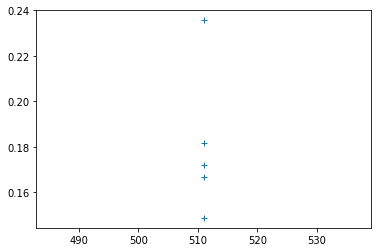

In [37]:
plt.plot(Ranks,NRMSEs,'+')
plt.show()

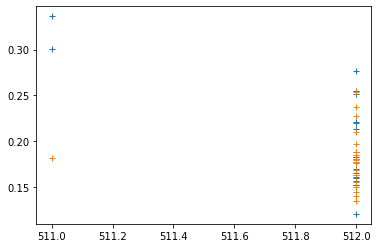

In [49]:
plt.plot(Ranks_1,NRMSEs_1,'+')
plt.plot(Ranks_2,NRMSEs_2,'+')
plt.show()

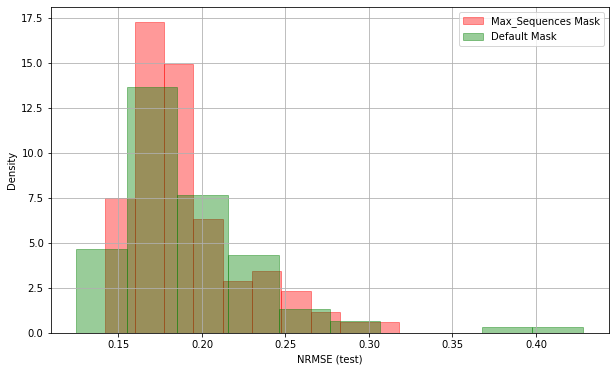

In [84]:
plt.figure(figsize=(10,6))
plt.hist(NRMSEs_2,color = "red", edgecolor = "red", alpha=.4,bins = 10,label = "Max_Sequences Mask",density=True)
plt.hist(NRMSEs_1,color = "green", edgecolor = "green", alpha=.4,bins = 10,label = "Default Mask",density=True)
plt.legend(loc="best")
plt.grid(True)
plt.xlabel("NRMSE (test)")
plt.ylabel("Density")
plt.show()

In [23]:
Nv = 512
T_theta = 1e-2
m0 = 1
gamma = .7

net1 = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type="Default")
net2 = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type="Max_Sequences")

auto_corr_1 = get_auto_correlation_func(net1)
auto_corr_2 = get_auto_correlation_func(net2)

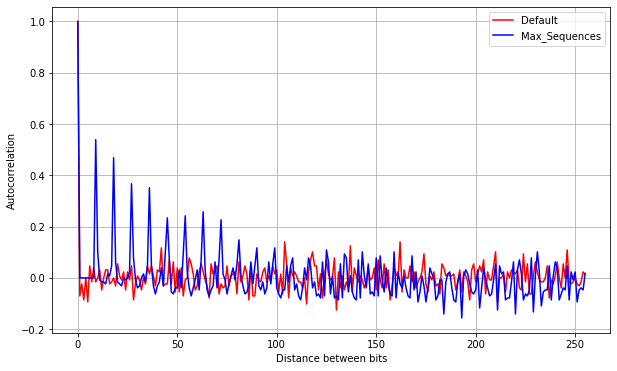

In [26]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(auto_corr_1,'r-',label="Default")
plt.plot(auto_corr_2,'b-',label="Max_Sequences")
plt.legend(loc="best")
plt.xlabel("Distance between bits")
plt.ylabel("Autocorrelation")
plt.show()

In [42]:
p = 9
Nv = 2**p
T_theta = 1e-2
m0 = 1
gamma = .7

net1 = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type="Default")
net2 = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type="Max_Sequences")

counter_1 = count_seq_net(net1,p)
counter_2 = count_seq_net(net2,p)
counter_3 = count_mult_seq_net(net1,p)
counter_4 = count_mult_seq_net(net2,p)

In [35]:
print(2**p-len(counter_1.values()))
print(2**p-len(counter_2.values()))

191
0


In [36]:
print(2**p-len(counter_3.values()))
print(2**p-len(counter_4.values()))

191
0


In [43]:
print(get_rank(net1))
print(get_rank(net2))
print(get_mult_rank(net1))
print(get_mult_rank(net2))

512
511
512
512


In [14]:
p = 7
Nv = 2**p
T_theta = 1e-2
m0 = 1
gamma = .7

net2 = Single_Node_Reservoir_NARMA10(Nv,T_theta,m0,gamma,mask_type="Max_Sequences")

In [15]:
mask = []

for m in net2.M:
    mask.append(int(m))

In [16]:
print(mask)

[1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1]
